In [114]:
%matplotlib inline
from linescanning import(
    prf,
    plotting,
    fitting,
    optimal,
    utils,
    glm
) 

import numpy as np
import os
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt

opd = os.path.dirname
opj = os.path.join

In [2]:
# load data
prf_file    = "/mnt/d/FSL/shared/spinoza/projects/WB-pRF/derivatives/prf/sub-008/ses-1/sub-008_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl"
pars_obj    = optimal.pRFCalc(prf_file)
data        = np.load(opj(opd(prf_file), "sub-008_ses-1_task-2R_hemi-LR_desc-avg_bold.npy"))


In [31]:
design = prf.get_prfdesign("/mnt/d/FSL/shared/spinoza/projects/WB-pRF/sourcedata/sub-008/ses-1/sub-008_ses-1_task-2R_run-1_Logs/sub-008_ses-1_task-2R_run-1_Screenshots", n_pix=1080)

In [35]:
# resample
design_rs = utils.resample2d(design, 100)
design_rs[design_rs < 0.9] = 0


In [3]:
highest_r2 = np.where(pars_obj.r2 == np.amax(pars_obj.r2))[0][0]
tc = data[:,highest_r2][np.newaxis,...]
tc.shape


(1, 225)

In [89]:
# load existing parameters
load = prf.pRFmodelFitting(
    data.T,
    design_matrix=design_rs,
    TR=1.5,
    verbose=True
)

load.load_params(pars_obj.prf_params, model='gauss', stage='iter')

Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f6c5b6ddd00>
Inserting parameters from <class 'numpy.ndarray'> as 'gauss_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f6c5a7b3b80>


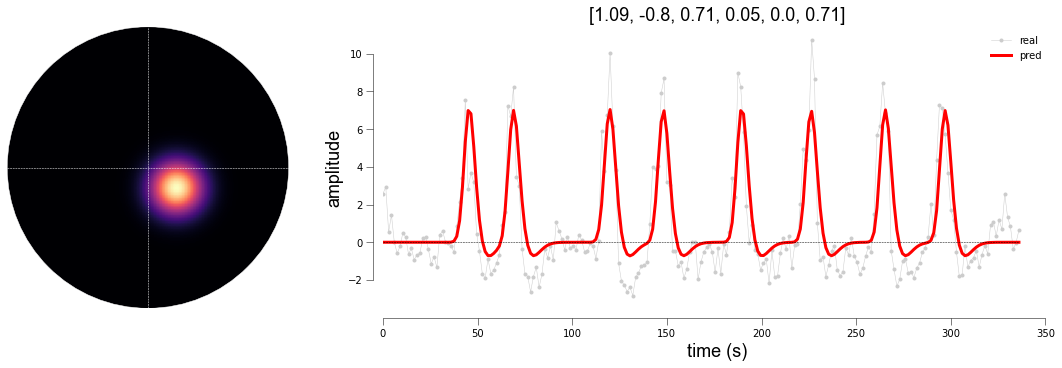

In [90]:
_,_,_,_ = load.plot_vox(vox_nr=highest_r2, title='pars', axis_type='time')

In [84]:
gauss = prf.pRFmodelFitting(tc,
                            design_matrix=design_rs,
                            TR=1.5,
                            model='gauss',
                            stage="grid+iter",
                            verbose=True,
                            fix_bold_baseline=True
                            )
gauss.fit()


Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f6c5aac5bb0>
Starting gauss grid fit at 2022/08/12 12:48:33
Gaussian gridfit completed at 2022/08/12 12:48:44. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:10.712451
Mean rsq>0.1: 0.74
Starting gauss iterfit at 2022/08/12 12:48:44
Gaussian iterfit completed at 2022/08/12 12:48:47. Mean rsq>0.1: 0.72
Iterfit took 0:00:02.846744


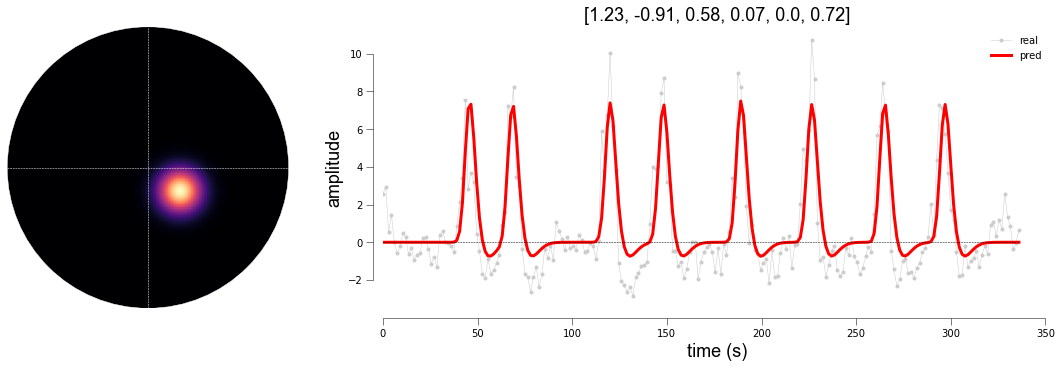

In [139]:
_,prf_,bold,pred = gauss.plot_vox(vox_nr=0, title='pars', axis_type='time')
pred = np.squeeze(pred)

In [143]:
# spatially smooth the pRF
prf_ = utils.resample2d(prf_, 1080)
cmap_prf = utils.make_binary_cm("#08B2F0")
cmap_stim = utils.make_binary_cm("#cccccc")

for tp in range(gauss.design_matrix.shape[-1]):

    # initiate figure
    fig = plt.figure(constrained_layout=True, figsize=(15,5))
    gs00 = fig.add_gridspec(1,2, width_ratios=[10,20])

    # add pRF plot
    ax1 = fig.add_subplot(gs00[0])
    plotting.LazyPRF(
        prf_,
        vf_extent=[-5,5], 
        ax=ax1,
        cmap=cmap_prf,
        shrink_factor=0.9,
        cross_color='k')

    # stim = utils.resample2d(gauss.design_matrix[..., tp], prf_.shape[0])
    stim = design[..., tp]
    ax1.imshow(
        stim, 
        cmap=cmap_stim,
        extent=[-5,5]+[-5,5],
        alpha=0.7)

    # add timecourse plot
    x_axis = np.array(list(np.arange(0,tc.shape[1])*gauss.TR))
    ax2 = fig.add_subplot(gs00[1])

    tc1 = np.full_like(bold, np.nan)
    tc2 = tc1.copy()
    tc1[:tp] = bold[:tp]
    tc2[:tp] = pred[:tp]

    plotting.LazyPlot(
        [tc1, tc2],
        xx=x_axis,
        color=['#cccccc', 'r'], 
        labels=['real', 'pred'], 
        add_hline='default',
        x_label="time (s)",
        y_label="amplitude",
        axs=ax2,
        font_size=18,
        line_width=[0.5, 3],
        markers=['.', None],
        x_lim=(0,x_axis[-1]+20),
        y_lim=(-3,10)
    )
    
    plt.close(fig)
    fname = opj(opd(opd(prf_file)), 'figures', f'{str(tp).zfill(len(str(design.shape[-1])))}.svg')
    fig.savefig(fname, facecolor='white')

cmd = f'ffmpeg -framerate 5 -pattern_type glob -i "{opd(fname)}/*.svg" -q:v 0 -c:v mpeg4 {opj(opd(fname), "prf2.mp4")} -y'
os.system(cmd)


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

# pRF fitting procedure

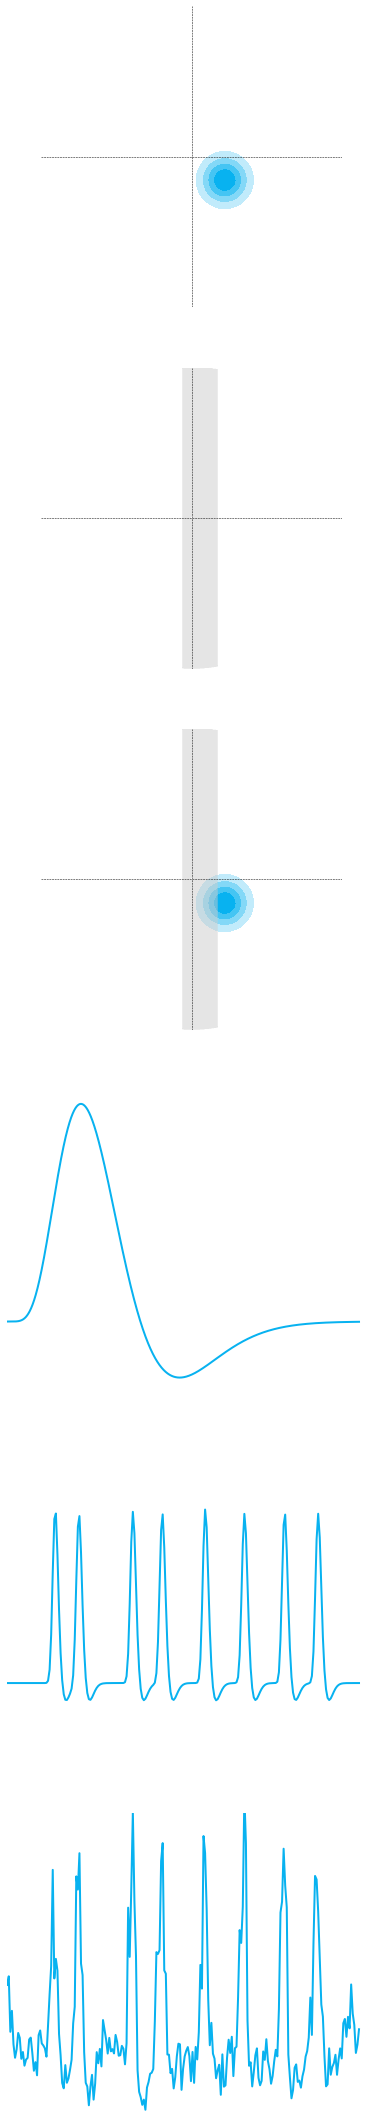

In [136]:
fig, ax = plt.subplots(figsize=(6,30))
gs = fig.add_gridspec(6,1, wspace=0.2)
blue_color = "#08B2F0"

plot_prf = utils.resample2d(prf_, 1080)

# plot 1: pRF model
ax1 = fig.add_subplot(gs[0])
plotting.LazyPRF(
    plot_prf,
    vf_extent=[-5,5], 
    ax=ax1,
    cmap=cmap_prf,
    shrink_factor=0.9,
    cross_color='k',
    line_width=0)

# plot 2: stimulus aperture
ax2 = fig.add_subplot(gs[1])
plotting.LazyPRF(
    plot_prf,
    vf_only=True,
    vf_extent=[-5,5], 
    ax=ax2,
    cmap=cmap_prf,
    shrink_factor=0.9,
    cross_color='k',
    line_width=0)

ax2.imshow(
    design[...,25], 
    cmap=cmap_stim,
    extent=[-5,5]+[-5,5],
    alpha=0.5)
    
ax2.axis('off')

# plot 3: stimulus X pRF-model
ax3 = fig.add_subplot(gs[2])
plotting.LazyPRF(
    plot_prf,
    vf_extent=[-5,5], 
    ax=ax3,
    cmap=cmap_prf,
    shrink_factor=0.9,
    cross_color='k',
    line_width=0)

ax3.imshow(
    design[...,25], 
    cmap=cmap_stim,
    extent=[-5,5]+[-5,5],
    alpha=0.5)
    
# plot 4: hrf
ax4 = fig.add_subplot(gs[3])
dt = 1/1000
time_points = np.linspace(0, 25, np.rint(float(25)/dt).astype(int))
hrf = glm.double_gamma(time_points, lag=6)
plotting.LazyPlot(hrf, axs=ax4, color=blue_color, line_width=2)
ax4.axis('off')

# plot 5: prediction
ax5 = fig.add_subplot(gs[4])
plotting.LazyPlot(
    pred,
    xx=x_axis,
    color=blue_color, 
    axs=ax5,
    line_width=2,
    y_lim=(-3,10))

ax5.axis('off')

# plot 6: data
ax6 = fig.add_subplot(gs[5])
plotting.LazyPlot(
    bold,
    axs=ax6,
    xx=x_axis,
    color=blue_color, 
    line_width=2,
    y_lim=(-3,10))

ax6.axis('off')
fig.tight_layout()

for ax in fig.axes:
    ax.axis('off')

fname = opj(opd(opd(prf_file)), 'figures', f'pRF_procedure_v.pdf')
fig.savefig(fname)


In [125]:
prf_.shape

(100, 100)

# Correct vs incorrect fit

below I am to illustrate the iterative nature of pRF fitting 

In [113]:
# get different parameters by finding a vertex that's closest to r2 = some value

for ix,val in enumerate([0.4, 0.5, 'orig']):

    if isinstance(val, str):
        some_pars,prf_,_,pred = gauss.plot_vox(vox_nr=0, title='pars', axis_type='time', make_figure=False)
    else:
        some_idx = utils.find_nearest(load.gauss_iter[:,-1], val)[0]
        some_pars,prf_,_,pred = load.plot_vox(vox_nr=some_idx, title='pars', axis_type='time', make_figure=False)

    # initiate figure
    fig = plt.figure(constrained_layout=True, figsize=(15,5))
    gs00 = fig.add_gridspec(1,2, width_ratios=[10,20])

    # add pRF plot
    ax1 = fig.add_subplot(gs00[0])
    plotting.LazyPRF(
        prf_,
        vf_extent=[-5,5], 
        ax=ax1,
        resize_pix=270)

    # add timecourse plot
    x_axis = np.array(list(np.arange(0,tc.shape[1])*gauss.TR))
    ax2 = fig.add_subplot(gs00[1])

    plotting.LazyPlot(
        [bold, pred],
        xx=x_axis,
        color=['#cccccc', 'r'], 
        labels=['real', 'pred'], 
        add_hline='default',
        x_label="time (s)",
        y_label="amplitude",
        axs=ax2,
        font_size=18,
        line_width=[0.5, 3],
        markers=['.', None],
        x_lim=(0,x_axis[-1]+20),
        y_lim=(-3,10),
        title=[round(ii,2) for ii in some_pars]
    )

    plt.close(fig)
    fname = opj(opd(opd(prf_file)), 'figures', f'attempt_{ix+1}.svg')
    fig.savefig(fname, facecolor='white')


# L-BGFS v Trust-constraint

In [91]:
norm = prf.pRFmodelFitting(
    tc,
    design_matrix=design_rs,
    TR=1.5,
    model='norm',
    stage="grid+iter",
    fix_bold_baseline=True,
    verbose=True)
    
norm.fit()

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f6c5b628460>
Starting gauss grid fit at 2022/08/12 13:15:26
Gaussian gridfit completed at 2022/08/12 13:15:38. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:11.948004
Mean rsq>0.1: 0.74
Starting gauss iterfit at 2022/08/12 13:15:38
Gaussian iterfit completed at 2022/08/12 13:15:42. Mean rsq>0.1: 0.72
Iterfit took 0:00:03.508264
Starting norm grid fit at 2022/08/12 13:15:42


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


norm gridfit completed at 2022/08/12 13:15:42. Mean rsq>0.1: 0.74
Gridfit took 0:00:00.634420
Starting norm iterfit at 2022/08/12 13:15:42
norm iterfit completed at 2022/08/12 13:17:07. Mean rsq>0.1: 0.75
Iterfit took 0:01:24.336435


In [92]:
norm_tc = prf.pRFmodelFitting(
    tc,
    design_matrix=design_rs,
    TR=1.5,
    model='norm',
    stage="grid+iter",
    verbose=True,
    fix_bold_baseline=True,
    constraints="tc")

norm_tc.fit()


Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f6c5a7d7e80>
Starting gauss grid fit at 2022/08/12 13:17:54
Gaussian gridfit completed at 2022/08/12 13:18:05. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:11.012772
Mean rsq>0.1: 0.74
Starting gauss iterfit at 2022/08/12 13:18:05
Gaussian iterfit completed at 2022/08/12 13:18:08. Mean rsq>0.1: 0.72
Iterfit took 0:00:02.931038
Starting norm grid fit at 2022/08/12 13:18:08


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


norm gridfit completed at 2022/08/12 13:18:09. Mean rsq>0.1: 0.74
Gridfit took 0:00:00.561632
Starting norm iterfit at 2022/08/12 13:18:09
norm iterfit completed at 2022/08/12 13:19:31. Mean rsq>0.1: 0.75
Iterfit took 0:01:22.460134


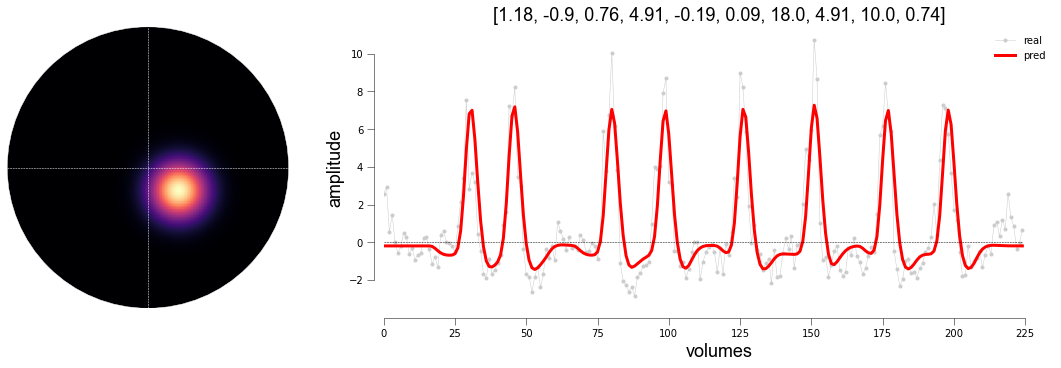

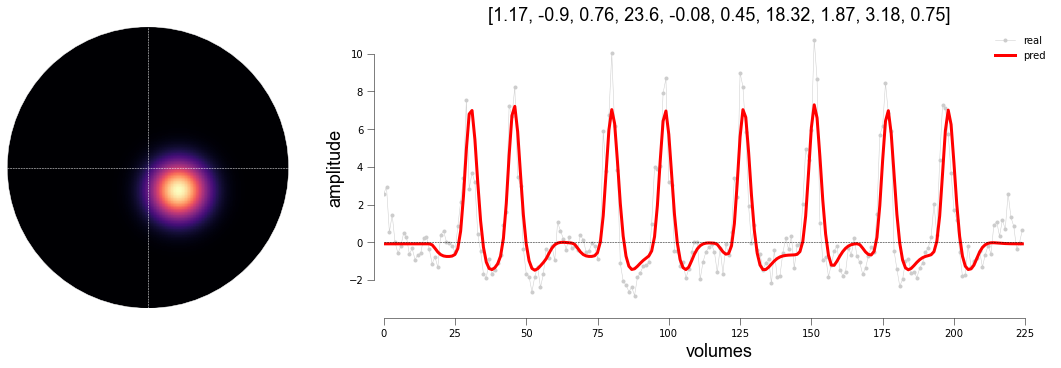

In [77]:
# plot the model fit
_,_,_,_ = norm.plot_vox(vox_nr=0, title='pars', model='norm')
_,_,_,_ = norm_tc.plot_vox(vox_nr=0, title='pars', model='norm')

In [81]:
norm.gauss_iter

array([[ 1.22699414, -0.91434991,  0.58015319,  0.06918173,  0.        ,
         0.72185663]])

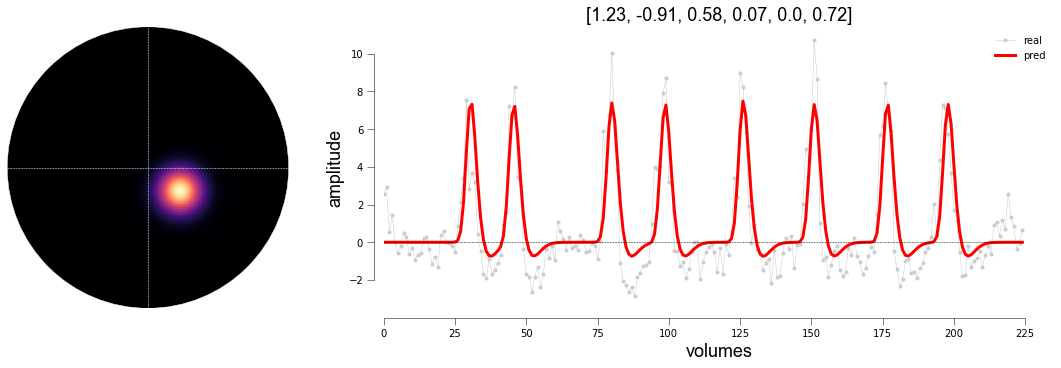

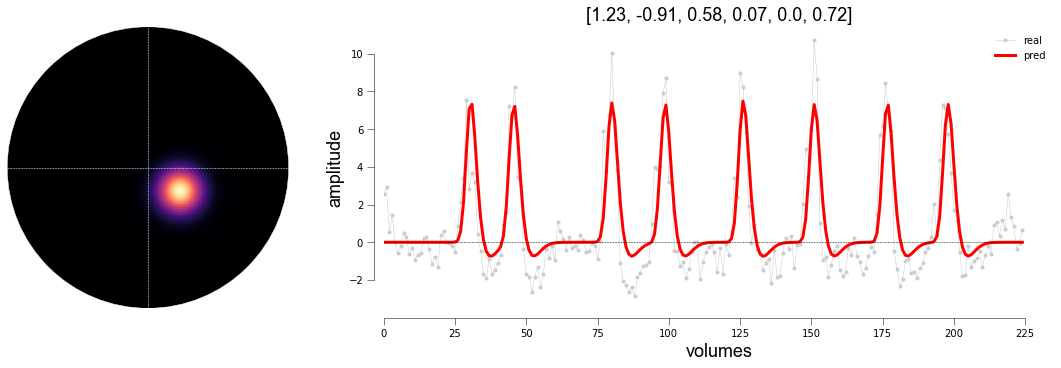

In [83]:
# plot the model fit
_,_,_,_ = norm.plot_vox(vox_nr=0, title='pars', model='gauss')
_,_,_,_ = norm_tc.plot_vox(vox_nr=0, title='pars', model='gauss')

In [82]:
norm.gauss_model